In [20]:
import pandas as pd
df = pd.read_csv('../Data/Cleaned/historical_disaster_data.csv')
df

,YEAR,STATE,EVENT_TYPE,TOTAL_INJURIES,TOTAL_DEATHS,TOTAL_DAMAGE,Per_Capita_Emissions,NASA_Global_Temp_Anomaly_C,BEGIN_LAT,BEGIN_LON
0,2014,ILLINOIS,Flash Flood,0.0,0.0,2.000000e+07,19.926178,0.75,39.8967,-89.11250
1,2014,CALIFORNIA,High Surf,1.0,0.0,4.000000e+07,19.926178,0.75,34.4421,-122.88333
2,2014,CALIFORNIA,Drought,0.0,0.0,1.500000e+09,19.926178,0.75,34.4421,-122.88333
3,2014,MISSISSIPPI,Tornado,50.0,3.0,2.500000e+07,19.926178,0.75,31.2273,-89.83310
4,2014,NEW JERSEY,Winter Weather,115.0,1.0,0.000000e+00,19.926178,0.75,39.5000,-75.42000
...,...,...,...,...,...,...,...,...,...,...
4375,1999,MISSOURI,Heat,142.0,35.0,0.000000e+00,24.709019,0.38,36.6200,-94.61860
4376,1999,OHIO,Heat,0.0,13.0,0.000000e+00,24.709019,0.38,39.2300,-82.95000
4377,1999,DISTRICT OF COLUMBIA,Heat,140.0,3.0,0.000000e+00,24.709019,0.38,38.9174,-77.08980
4378,1999,MARYLAND,Heat,200.0,15.0,0.000000e+00,24.709019,0.38,38.5500,-77.39570


In [6]:
df.dtypes

YEAR                            int64
STATE                          object
EVENT_TYPE                     object
TOTAL_INJURIES                float64
TOTAL_DEATHS                  float64
TOTAL_DAMAGE                  float64
Per_Capita_Emissions          float64
NASA_Global_Temp_Anomaly_C    float64
BEGIN_LAT                     float64
BEGIN_LON                     float64
dtype: object

### 1. Defining Severity

We'll create a new metric that combines Total Deaths, Total Injuries, and Total Damage. Here’s the formula we’ll use:

Severity Score=α×Deaths+β×Injuries+γ×log⁡(Damage+1)

- We'll start with equal weights (α=β=1α=β=1) and take the log of damage to reduce skew.
- Then we’ll categorize the scores into 4 classes: Least Severe, Less Severe, Severe, and Most Severe.

Classification Report:
               precision    recall  f1-score   support

Least Severe       0.76      0.98      0.86       412
 Less Severe       0.87      0.57      0.69       245
 Most Severe       0.88      0.98      0.92        44
      Severe       0.89      0.68      0.77       175

    accuracy                           0.81       876
   macro avg       0.85      0.80      0.81       876
weighted avg       0.82      0.81      0.80       876



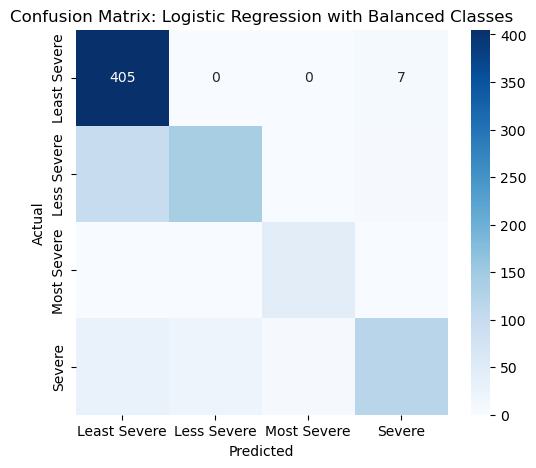

          Feature  Coefficient
0    TOTAL_DEATHS    -1.485184
1  TOTAL_INJURIES   -10.518912
2    TOTAL_DAMAGE   -12.546281
Model training and evaluation complete.


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Step 1: Create a severity score
# Formula: Severity = Deaths + Injuries + log(Damage+1)
df['Severity_Score'] = df['TOTAL_DEATHS'] + df['TOTAL_INJURIES'] + np.log1p(df['TOTAL_DAMAGE'])

# Step 2: Define severity categories
percentiles = df['Severity_Score'].quantile([0.5, 0.75, 0.95])
def classify_severity(score):
    if score >= percentiles[0.95]:
        return 'Most Severe'
    elif score >= percentiles[0.75]:
        return 'Severe'
    elif score >= percentiles[0.5]:
        return 'Less Severe'
    else:
        return 'Least Severe'

df['Severity_Level'] = df['Severity_Score'].apply(classify_severity)

# Step 3: Prepare features and target
X = df[['TOTAL_DEATHS', 'TOTAL_INJURIES', 'TOTAL_DAMAGE']]
y = df['Severity_Level']

# Step 4: Feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: Train a multinomial logistic regression with class balancing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

# Step 6: Evaluate the model
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Step 7: Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix: Logistic Regression with Balanced Classes')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 8: Analyze feature coefficients
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_[0]})
print(coefficients.sort_values(by='Coefficient', ascending=False))

print("Model training and evaluation complete.")


### Class by Class Evaluation
    
#### Least Severe:
- Precision: 0.76 – 76% of predicted "Least Severe" events were correct.
- Recall: 0.98 – Almost all actual "Least Severe" events were identified correctly.

##### Insight: 
- The model confidently identifies non-severe events but may incorrectly label other classes as "Least Severe."

#### Less Severe:
- Precision: 0.87 – Most predictions for this class are accurate.
- Recall: 0.57 – Only 57% of actual "Less Severe" events were identified correctly.

##### Insight: 
- Model struggles to capture "Less Severe" events, often misclassifying them.

#### Most Severe:
- Precision: 0.88 – High precision, meaning few false alarms for "Most Severe" predictions.
- Recall: 0.98 – Model identifies nearly all true "Most Severe" events.

##### Insight: 
- Model performs exceptionally well for the most dangerous events.

#### Severe:
- Precision: 0.89 – Strong performance in identifying true severe events.
- Recall: 0.68 – Misses about one-third of actual "Severe" events.

##### Insight: 
- Model tends to confuse these events with less severe categories.

Overall:

    Accuracy: 81% – Solid performance overall.
    Macro Average: 85% precision, 80% recall – Balanced across categories.
    Weighted Average: 82% precision, 81% recall – Weighted by class size.

#### Coefficients:
- TOTAL_DAMAGE has the strongest impact: A large increase makes events more likely to be classified as severe.
- TOTAL_INJURIES also strongly influences severity, more so than deaths.
- TOTAL_DEATHS has the least relative impact.

Classification Report:
               precision    recall  f1-score   support

Least Severe       0.78      0.98      0.87       412
 Less Severe       0.88      0.80      0.84       412
 Most Severe       0.96      1.00      0.98       412
      Severe       0.94      0.74      0.83       412

    accuracy                           0.88      1648
   macro avg       0.89      0.88      0.88      1648
weighted avg       0.89      0.88      0.88      1648



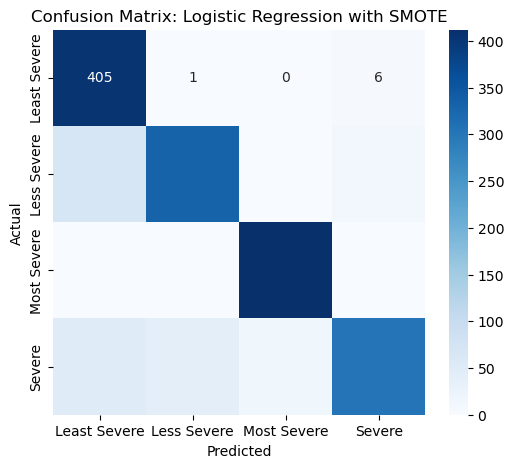

          Feature  Coefficient
0    TOTAL_DEATHS    -1.792953
1  TOTAL_INJURIES   -14.518523
2    TOTAL_DAMAGE   -17.201381
Model training and evaluation complete.


In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Step 1: Create a severity score
# Formula: Severity = Deaths + Injuries + log(Damage+1)
df['Severity_Score'] = df['TOTAL_DEATHS'] + df['TOTAL_INJURIES'] + np.log1p(df['TOTAL_DAMAGE'])

# Step 2: Define severity categories
percentiles = df['Severity_Score'].quantile([0.5, 0.75, 0.95])
def classify_severity(score):
    if score >= percentiles[0.95]:
        return 'Most Severe'
    elif score >= percentiles[0.75]:
        return 'Severe'
    elif score >= percentiles[0.5]:
        return 'Less Severe'
    else:
        return 'Least Severe'

df['Severity_Level'] = df['Severity_Score'].apply(classify_severity)

# Step 3: Prepare features and target
X = df[['TOTAL_DEATHS', 'TOTAL_INJURIES', 'TOTAL_DAMAGE']]
y = df['Severity_Level']

# Step 4: Feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: Apply SMOTE to balance 'Less Severe' and 'Severe' classes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Step 6: Train a multinomial logistic regression with class balancing
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

# Step 7: Evaluate the model
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Step 8: Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix: Logistic Regression with SMOTE')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 9: Analyze feature coefficients
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_[0]})
print(coefficients.sort_values(by='Coefficient', ascending=False))

print("Model training and evaluation complete.")


**SMOTE** stands for **Synthetic Minority Over-sampling Technique**. It is used to address class imbalance by generating synthetic samples for the minority class.

### **How SMOTE Works**

1. **Identify a minority class instance.**  
2. **Find its `k` nearest neighbors.**  
3. **Randomly select one neighbor.**  
4. **Generate a synthetic point along the line connecting the instance and its neighbor.**

The new point is placed at a random position between the two original points, following the equation:

\[
\text{Synthetic Point} = x_1 + \lambda \times (x_2 - x_1)
\]

where:  
- \(x_1\) = original minority instance  
- \(x_2\) = selected neighbor  
- \(\lambda\) = random value between 0 and 1  

---

### **Why Use SMOTE?**

- **Balances the dataset** by generating new, realistic samples rather than duplicating existing ones.  
- **Improves model generalization** by making decision boundaries clearer.  
- **Helps logistic regression models** handle previously underrepresented classes better.

---

### **Potential Pitfalls of SMOTE**

- Can introduce **noise** if the minority class has highly variable patterns.  
- SMOTE assumes that minority class instances are similar; if the class has clusters, **cluster-based SMOTE** might be better.  
- For high-dimensional datasets, synthetic samples may become less meaningful.


Classification Report:
               precision    recall  f1-score   support

Least Severe       0.88      0.94      0.91       412
 Less Severe       0.86      0.85      0.85       412
 Most Severe       0.96      1.00      0.98       412
      Severe       0.96      0.86      0.91       412

    accuracy                           0.91      1648
   macro avg       0.91      0.91      0.91      1648
weighted avg       0.91      0.91      0.91      1648



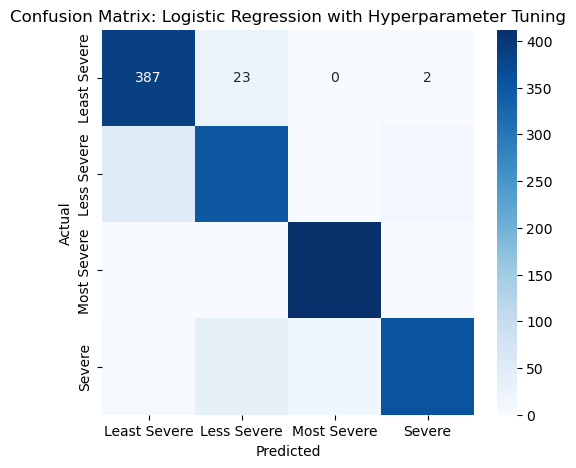

          Feature  Coefficient
0    TOTAL_DEATHS    -4.857334
2    TOTAL_DAMAGE   -65.326733
1  TOTAL_INJURIES  -114.487228
Model training and evaluation complete.


In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE


# Step 1: Create a severity score
# Formula: Severity = Deaths + Injuries + log(Damage+1)
df['Severity_Score'] = df['TOTAL_DEATHS'] + df['TOTAL_INJURIES'] + np.log1p(df['TOTAL_DAMAGE'])

# Step 2: Define severity categories
percentiles = df['Severity_Score'].quantile([0.5, 0.75, 0.95])
def classify_severity(score):
    if score >= percentiles[0.95]:
        return 'Most Severe'
    elif score >= percentiles[0.75]:
        return 'Severe'
    elif score >= percentiles[0.5]:
        return 'Less Severe'
    else:
        return 'Least Severe'

df['Severity_Level'] = df['Severity_Score'].apply(classify_severity)

# Step 3: Prepare features and target
X = df[['TOTAL_DEATHS', 'TOTAL_INJURIES', 'TOTAL_DAMAGE']]
y = df['Severity_Level']

# Step 4: Feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: Apply SMOTE to balance 'Less Severe' and 'Severe' classes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Step 6: Hyperparameter tuning with GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'saga'],
    'class_weight': [None, 'balanced']
}
model = LogisticRegression(multi_class='multinomial', max_iter=5000)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_resampled, y_resampled)

best_model = grid_search.best_estimator_

# Step 7: Train the best model
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)
best_model.fit(X_train, y_train)

# Step 8: Evaluate the model
y_pred = best_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Step 9: Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title('Confusion Matrix: Logistic Regression with Hyperparameter Tuning')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 10: Analyze feature coefficients
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': best_model.coef_[0]})
print(coefficients.sort_values(by='Coefficient', ascending=False))

print("Model training and evaluation complete.")


# **Understanding SMOTE-ENN for Model Optimization**

## **What is SMOTE-ENN?**

**SMOTE-ENN** stands for **Synthetic Minority Over-sampling Technique with Edited Nearest Neighbors**. It is a hybrid approach that combines:

1. **SMOTE (Synthetic Minority Over-sampling Technique)** – Generates synthetic samples to balance class distribution.
2. **ENN (Edited Nearest Neighbors)** – Removes samples that are likely misclassified, cleaning the decision boundaries.

### **How It Works:**

1. **SMOTE Phase:**
    - Synthetic samples are generated using the same technique described earlier.
2. **ENN Phase:**
    - For each sample, its `k` nearest neighbors are analyzed.
    - If a sample is misclassified based on its neighbors, it is removed, reducing noise.

### **Benefits:**
- Improves class balance while maintaining clean, distinct decision boundaries.
- Reduces the chance of overfitting by eliminating noisy samples.

### **Potential Drawbacks:**
- May remove too many samples if classes are highly overlapping.
- Can be computationally intensive for large datasets.


Classification Report:
               precision    recall  f1-score   support

Least Severe       0.88      0.94      0.91       412
 Less Severe       0.87      0.85      0.86       408
 Most Severe       0.98      1.00      0.99       405
      Severe       0.95      0.89      0.92       397

    accuracy                           0.92      1622
   macro avg       0.92      0.92      0.92      1622
weighted avg       0.92      0.92      0.92      1622



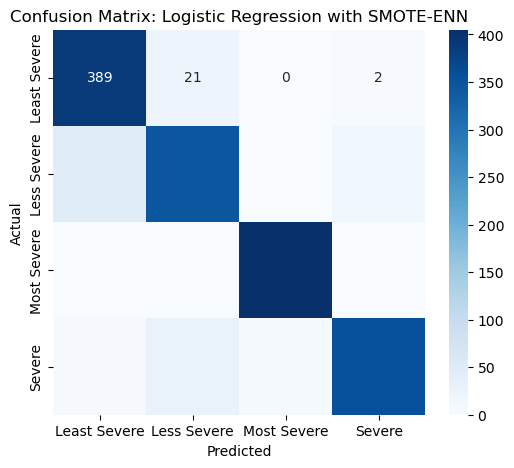

          Feature  Coefficient
0    TOTAL_DEATHS    -4.860376
2    TOTAL_DAMAGE   -64.971962
1  TOTAL_INJURIES  -117.558814
Model training and evaluation complete.


In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.combine import SMOTEENN


# Step 1: Create a severity score
# Formula: Severity = Deaths + Injuries + log(Damage+1)
df['Severity_Score'] = df['TOTAL_DEATHS'] + df['TOTAL_INJURIES'] + np.log1p(df['TOTAL_DAMAGE'])

# Step 2: Define severity categories
percentiles = df['Severity_Score'].quantile([0.5, 0.75, 0.95])
def classify_severity(score):
    if score >= percentiles[0.95]:
        return 'Most Severe'
    elif score >= percentiles[0.75]:
        return 'Severe'
    elif score >= percentiles[0.5]:
        return 'Less Severe'
    else:
        return 'Least Severe'

df['Severity_Level'] = df['Severity_Score'].apply(classify_severity)

# Step 3: Prepare features and target
X = df[['TOTAL_DEATHS', 'TOTAL_INJURIES', 'TOTAL_DAMAGE']]
y = df['Severity_Level']

# Step 4: Feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: Apply SMOTE-ENN to balance and clean the dataset
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_scaled, y)

# Step 6: Hyperparameter tuning with GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'saga'],
    'class_weight': [None, 'balanced']
}
model = LogisticRegression(multi_class='multinomial', max_iter=5000)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_resampled, y_resampled)

best_model = grid_search.best_estimator_

# Step 7: Train the best model
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)
best_model.fit(X_train, y_train)

# Step 8: Evaluate the model
y_pred = best_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Step 9: Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title('Confusion Matrix: Logistic Regression with SMOTE-ENN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 10: Analyze feature coefficients
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': best_model.coef_[0]})
print(coefficients.sort_values(by='Coefficient', ascending=False))

print("Model training and evaluation complete.")

Introducing epa per capita emissions and global temperature anamolies

Classification Report:
               precision    recall  f1-score   support

Least Severe       0.89      0.93      0.91       412
 Less Severe       0.84      0.85      0.85       412
 Most Severe       0.98      1.00      0.99       412
      Severe       0.96      0.88      0.92       412

    accuracy                           0.92      1648
   macro avg       0.92      0.92      0.92      1648
weighted avg       0.92      0.92      0.92      1648



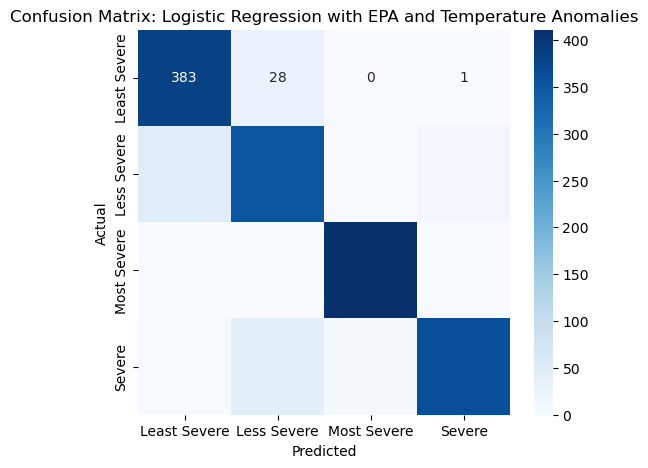

                      Feature  Coefficient
4  NASA_Global_Temp_Anomaly_C     0.207296
3        Per_Capita_Emissions    -0.167788
0                TOTAL_DEATHS    -5.228001
2                TOTAL_DAMAGE   -68.827914
1              TOTAL_INJURIES  -117.229268
Model training and evaluation complete.


In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

# Step 1: Create a severity score
# Formula: Severity = Deaths + Injuries + log(Damage+1)
df['Severity_Score'] = df['TOTAL_DEATHS'] + df['TOTAL_INJURIES'] + np.log1p(df['TOTAL_DAMAGE'])

# Step 2: Define severity categories
percentiles = df['Severity_Score'].quantile([0.5, 0.75, 0.95])
def classify_severity(score):
    if score >= percentiles[0.95]:
        return 'Most Severe'
    elif score >= percentiles[0.75]:
        return 'Severe'
    elif score >= percentiles[0.5]:
        return 'Less Severe'
    else:
        return 'Least Severe'

df['Severity_Level'] = df['Severity_Score'].apply(classify_severity)

# Step 3: Prepare features and target
X = df[['TOTAL_DEATHS', 'TOTAL_INJURIES', 'TOTAL_DAMAGE', 'Per_Capita_Emissions', 'NASA_Global_Temp_Anomaly_C']]
y = df['Severity_Level']

# Step 4: Handle missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Step 5: Feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Step 6: Apply SMOTE to balance 'Less Severe' and 'Severe' classes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Step 7: Hyperparameter tuning with GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'saga'],
    'class_weight': [None, 'balanced']
}
model = LogisticRegression(multi_class='multinomial', max_iter=5000)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_resampled, y_resampled)

best_model = grid_search.best_estimator_

# Step 8: Train the best model
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)
best_model.fit(X_train, y_train)

# Step 9: Evaluate the model
y_pred = best_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Step 10: Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title('Confusion Matrix: Logistic Regression with EPA and Temperature Anomalies')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 11: Analyze feature coefficients
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': best_model.coef_[0]})
print(coefficients.sort_values(by='Coefficient', ascending=False))

print("Model training and evaluation complete.")


We see that epa per capita emissions and temperature anamolies have little immediate effect on storm severity. That is not to say that is not a delayed correlation, however, at given our current capabilities this remains theoretical.

We end up going with the model with epa per capita emissions and temperature anamolies for greater user interactivity with tableau dashboards

Classification Report:
               precision    recall  f1-score   support

Least Severe       0.89      0.93      0.91       412
 Less Severe       0.84      0.85      0.85       412
 Most Severe       0.98      1.00      0.99       412
      Severe       0.96      0.88      0.92       412

    accuracy                           0.92      1648
   macro avg       0.92      0.92      0.92      1648
weighted avg       0.92      0.92      0.92      1648



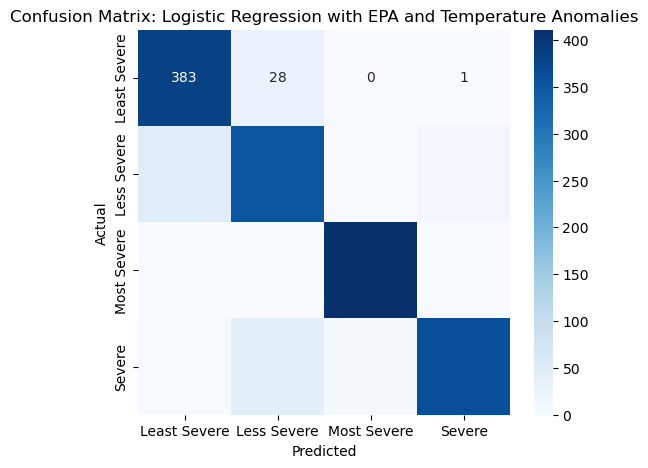

                      Feature  Coefficient
4  NASA_Global_Temp_Anomaly_C     0.207296
3        Per_Capita_Emissions    -0.167788
0                TOTAL_DEATHS    -5.228001
2                TOTAL_DAMAGE   -68.827914
1              TOTAL_INJURIES  -117.229268
Data for Tableau dashboard saved as 'historical_disaster_dashboard.csv'
Model training and evaluation complete.


In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

# Step 1: Create a severity score
# Formula: Severity = Deaths + Injuries + log(Damage+1)
df['Severity_Score'] = df['TOTAL_DEATHS'] + df['TOTAL_INJURIES'] + np.log1p(df['TOTAL_DAMAGE'])

# Step 2: Define severity categories
percentiles = df['Severity_Score'].quantile([0.5, 0.75, 0.95])
def classify_severity(score):
    if score >= percentiles[0.95]:
        return 'Most Severe'
    elif score >= percentiles[0.75]:
        return 'Severe'
    elif score >= percentiles[0.5]:
        return 'Less Severe'
    else:
        return 'Least Severe'

df['Severity_Level'] = df['Severity_Score'].apply(classify_severity)

# Step 3: Prepare features and target
X = df[['TOTAL_DEATHS', 'TOTAL_INJURIES', 'TOTAL_DAMAGE', 'Per_Capita_Emissions', 'NASA_Global_Temp_Anomaly_C']]
y = df['Severity_Level']

# Step 4: Handle missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Step 5: Feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Step 6: Apply SMOTE to balance 'Less Severe' and 'Severe' classes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Step 7: Hyperparameter tuning with GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'saga'],
    'class_weight': [None, 'balanced']
}
model = LogisticRegression(multi_class='multinomial', max_iter=5000)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_resampled, y_resampled)

best_model = grid_search.best_estimator_

# Step 8: Train the best model
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)
best_model.fit(X_train, y_train)

# Step 9: Evaluate the model
y_pred = best_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Step 10: Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title('Confusion Matrix: Logistic Regression with EPA and Temperature Anomalies')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 11: Analyze feature coefficients
try:
    coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': best_model.coef_[0]})
    print(coefficients.sort_values(by='Coefficient', ascending=False))
except AttributeError:
    print("Model does not have 'coef_' attribute. Coefficients may be unavailable with this solver.")

# Step 12: Prepare data for Tableau
output_df = df[['YEAR', 'STATE', 'EVENT_TYPE', 'TOTAL_INJURIES', 'TOTAL_DEATHS', 'TOTAL_DAMAGE',
                 'Per_Capita_Emissions', 'NASA_Global_Temp_Anomaly_C', 'BEGIN_LAT', 'BEGIN_LON', 'Severity_Level']]
output_df.to_csv('historical_disaster_dashboard.csv', index=False, header=True)

print("Data for Tableau dashboard saved as 'historical_disaster_dashboard.csv'")

print("Model training and evaluation complete.")
